In [2]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')

In [17]:
def generate_2d_mixture_data(mus, sizes):
    """
    Generates 2d mixture data
    """
    subpop11 = np.random.normal(loc=mus[0], scale=1, size=sizes[0])
    subpop12 = np.random.normal(loc=mus[0], scale=1, size=sizes[0])
    subpop21 = np.random.normal(loc=mus[1], scale=1, size=sizes[1])
    subpop22 = np.random.normal(loc=mus[1], scale=1, size=sizes[1])
    mixture1 = np.concatenate([subpop11, subpop21])
    mixture2 = np.concatenate([subpop12, subpop22])
    return np.array([mixture1,mixture2])

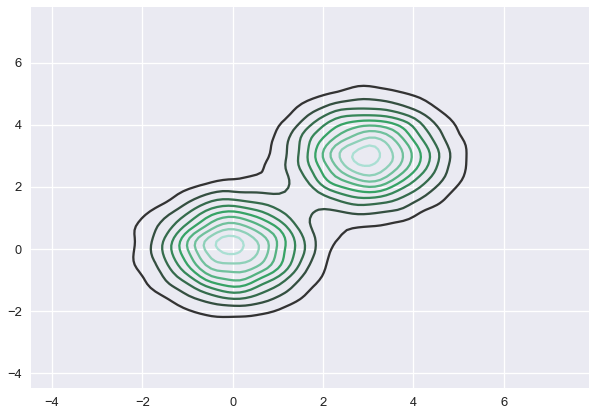

In [29]:
n_samples = 20000
mixture = generate_2d_mixture_data(mus=[0, 3], sizes=[20000, 20000])
fig1, ax1 = plt.subplots(figsize=(10,7))
sns.kdeplot(mixture[0,:], mixture[1,:], ax=ax1)

In [30]:
mixture.T.shape

(40000, 2)

In [31]:
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

with pm.Model() as model:
    mus = [pm.MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(2)]
    pi = pm.Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = pm.DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=mixture.T)

In [35]:
with model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step, start=start)    
#     trace = pm.sample(draws=10000, n_init=5000)

logp = -56,826, ||grad|| = 108.8: 100%|██████████| 4/4 [00:00<00:00, 210.03it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pi_stickbreaking__]
>Metropolis: [mu_1]
>Metropolis: [mu_0]


AttributeError: Can't pickle local object 'logp_gmix.<locals>.logp_'